In [1]:
import numpy as np
import os,sys,glob,json,pickle
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import rc

import healpy as hp

import astropy.constants as const
import astropy.units as u
from astropy.cosmology import WMAP9 as cosmo
from astropy.coordinates import SkyCoord

import hasasia.sensitivity as hassen
import hasasia.sim as hassim
import hasasia.skymap as hassky

from enterprise.pulsar import Pulsar as ePulsar

In [2]:
rc('text',usetex=True)
rc('font',**{'family':'serif','serif':['Times New Roman'],'size':14})#,'weight':'bold'})

In [3]:
top_dir = '/Users/andrewkaiser/Documents/GradSchool/Research/nanograv'

pta_sim_dir = top_dir + '/pta_sim/pta_sim/'
sys.path.insert(0,pta_sim_dir)
import noise

In [4]:
psrs_mdc2_dir = top_dir + '/NANOGrav/MDC2/mdc2/group1/dataset_1a/'
noise_mdc2_file =  top_dir + '/NANOGrav/MDC2/mdc2/group1/group1_psr_noise.json'

pars_mdc2 = sorted(glob.glob(psrs_mdc2_dir+'*.par'))
tims_mdc2 = sorted(glob.glob(psrs_mdc2_dir+'*.tim'))
noise_mdc2 = noise.load_noise_files(noisepath=noise_mdc2_file)
print(len(pars_mdc2))

33


In [5]:
psrs_11yr_dir = top_dir + '/NANOGrav/BackgroundInjections/nano11/partim_new/'
noise_11yr_dir = top_dir + '/NANOGrav/BackgroundInjections/nano11/noisefiles_new/'

pars_11yr = sorted(glob.glob(psrs_11yr_dir+'*.par'))
tims_11yr = sorted(glob.glob(psrs_11yr_dir+'*.tim'))
noise_11yr = sorted(glob.glob(noise_11yr_dir+'*.txt'))
print(len(pars_11yr))

45


In [6]:
psrlist_11yr_file = top_dir + '/NANOGrav/BackgroundInjections/nano11/psrlist_Tg3yr.txt'
encoding = 'utf-8'
psr_list_bytes = np.loadtxt(psrlist_11yr_file,dtype='S42')
psr_list = []
for psr in psr_list_bytes:
    psr_list.append(psr.decode(encoding))
print(len(psr_list))

34


In [7]:
psrs_wn_only_dir = top_dir + '/NANOGrav/BackgroundInjections/FakePTA/'
pars_wn_only = sorted(glob.glob(psrs_wn_only_dir+'*.par'))
tims_wn_only = sorted(glob.glob(psrs_wn_only_dir+'*.tim'))
print(len(pars_wn_only))

36


In [8]:
def get_psrname(file,name_sep='_'):
    return file.split('/')[-1].split(name_sep)[0]

In [9]:
pars_11yr = [f for f in pars_11yr if get_psrname(f,name_sep='_') in psr_list]
tims_11yr = [f for f in tims_11yr if get_psrname(f,name_sep='_') in psr_list]
noise_11yr = [f for f in noise_11yr if get_psrname(f,name_sep='_') in psr_list]
len(pars_11yr), len(tims_11yr), len(noise_11yr)

(34, 34, 34)

In [10]:
pars_mdc2 = [f for f in pars_mdc2 if get_psrname(f,name_sep='.') in psr_list]
tims_mdc2 = [f for f in tims_mdc2 if get_psrname(f,name_sep='.') in psr_list]
noise_mdc2_11yr_psrs = {}
[noise_mdc2_11yr_psrs.update({f: noise_mdc2[f]}) for f in noise_mdc2.keys() if get_psrname(f,name_sep='_') in psr_list]
len(pars_mdc2), len(tims_mdc2), len(noise_mdc2)

(17, 17, 33)

In [11]:
#Get the pickled pulsars
injection_psr_file = top_dir + '/NANOGrav/BackgroundInjections' + \
    '/SimInject5/SimRuns/simGWB_1/enterprise_pickled_psrs.pickle'
with open(injection_psr_file, "rb") as f:
        ePsrs_injection = pickle.load(f)

In [12]:
def get_epsrs_from_par_tim(pars,tims):
    ePsrs = []
    for par,tim in zip(pars,tims):
        ePsr = ePulsar(par, tim,  ephem='DE436')
        ePsrs.append(ePsr)
        print('\rPSR {0} complete'.format(ePsr.name),end='',flush=True)
    return ePsrs

In [13]:
ePsrs_11yr = get_epsrs_from_par_tim(pars_11yr,tims_11yr)

PSR B1953+29 complete

PSR J0030+0451 complete

PSR J0613-0200 complete

PSR J1600-3053 complete

PSR J1713+0747 complete

PSR J1738+0333 complete

PSR J1744-1134 complete

PSR J1747-4036 complete

PSR J1853+1303 complete

PSR J1918-0642 complete

PSR J1923+2515 complete

PSR J1944+0907 complete

PSR J2010-1323 complete

PSR J2017+0603 complete

PSR J2145-0750 complete

PSR J2214+3000 complete

PSR J2317+1439 complete

In [14]:
ePsrs_mdc2 = get_epsrs_from_par_tim(pars_mdc2,tims_mdc2)

PSR J1600-3053 complete

PSR J1918-0642 complete

PSR J1944+0907 complete

PSR J2317+1439 complete

In [53]:
Tspan_11yr = hassen.get_Tspan(ePsrs_11yr)
print(Tspan_11yr*u.s.to('yr'))
Tspan_mdc2 = hassen.get_Tspan(ePsrs_mdc2)
Tspan_injection = hassen.get_Tspan(ePsrs_injection)

11.4213712532189


In [17]:
#Get Noise Values
noiseparams_mdc2 = noise.handle_noise_parameters(noise_mdc2_11yr_psrs)

In [18]:
noiseparams_injection = noise.handle_noise_parameters(noise_mdc2)

In [21]:
noiseparams_11yr = {}
for nf in noise_11yr:
    noiseparams_11yr.update(noise.get_noise_from_file(nf))

{'B1855+09_430_PUPPI_efac': 1.11896, 'B1855+09_L-wide_PUPPI_efac': 1.38104, 'B1855+09_430_ASP_efac': 1.16587, 'B1855+09_L-wide_ASP_efac': 1.08538, 'B1855+09_430_ASP_log10_ecorr': -8.47348, 'B1855+09_430_PUPPI_log10_ecorr': -6.31096, 'B1855+09_L-wide_ASP_log10_ecorr': -6.09208, 'B1855+09_L-wide_PUPPI_log10_ecorr': -6.401, 'B1855+09_430_PUPPI_log10_equad': -6.17415, 'B1855+09_L-wide_PUPPI_log10_equad': -6.53715, 'B1855+09_430_ASP_log10_equad': -7.93502, 'B1855+09_L-wide_ASP_log10_equad': -6.51038, 'B1855+09_red_noise_log10_A': -13.8022, 'B1855+09_red_noise_gamma': 3.63368, 'B1937+21_S-wide_ASP_efac': 1.38306, 'B1937+21_L-wide_PUPPI_efac': 2.51222, 'B1937+21_L-wide_ASP_efac': 2.08151, 'B1937+21_Rcvr_800_GUPPI_efac': 4.56347, 'B1937+21_S-wide_PUPPI_efac': 4.42791, 'B1937+21_Rcvr1_2_GASP_efac': 1.2136, 'B1937+21_Rcvr_800_GASP_efac': 2.28379, 'B1937+21_Rcvr1_2_GUPPI_efac': 1.51615, 'B1937+21_L-wide_ASP_log10_ecorr': -6.73728, 'B1937+21_L-wide_PUPPI_log10_ecorr': -6.89479, 'B1937+21_Rcvr1_2_G

In [22]:
fyr = 1/(365.25*24*3600)
freqs_11yr = np.logspace(np.log10(1/(5*Tspan_11yr)),np.log10(2e-7),600)
freqs_mdc2 = np.logspace(np.log10(1/(5*Tspan_mdc2)),np.log10(2e-7),600)
freqs_injection = np.logspace(np.log10(1/(5*Tspan_injection)),np.log10(2e-7),600)

In [23]:
def make_corr(psr,noisedict=None):
    N = psr.toaerrs.size
    corr = np.zeros((N,N))
    _, _, U = hassen.quantize_fast(psr.toas,psr.toaerrs,dt=1)
    u = np.matmul(U,U.T)
    sigma_sqr = np.zeros(N)
    ecorrs = np.zeros(N)
    if noisedict != None:
        keys = [ky for ky in noisedict.keys() if psr.name in ky]
        if 'f' in psr.flags.keys():
            backends = np.unique(psr.flags['f'])
            for be in backends:
                mask = np.where(psr.flags['f']==be)
                key_ec = '{0}_{1}_log10_{2}'.format(psr.name,be,'ecorr')
                ecorrs[mask] = np.ones_like(mask) * (10**noisedict[key_ec])**2
                key_ef = '{0}_{1}_{2}'.format(psr.name,be,'efac')
                key_eq = '{0}_{1}_log10_{2}'.format(psr.name,be,'equad')
                sigma_sqr[mask] = (noisedict[key_ef]**2 * (psr.toaerrs[mask]**2)
                                   + (10**noisedict[key_eq])**2)
        else:
            key_ef = '{0}_{1}'.format(psr.name,'efac')
            key_eq = '{0}_log10_{1}'.format(psr.name,'equad')
            sigma_sqr = (noisedict[key_ef]**2 * (psr.toaerrs**2)
                               + (10**noisedict[key_eq])**2)
    
    corr = np.diag(sigma_sqr) + np.diag(u*ecorrs**2)
    return corr

In [24]:
def get_hasasia_psr_from_epsrs(ePsrs,freqs,noisedict=None,thin=0,rn_psrs=None):
    psrs = []
    for ePsr in ePsrs:
        plaw = hassen.red_noise_powerlaw(A=9e-16, gamma=13/3., freqs=freqs)
        if rn_psrs != None:
            if ePsr.name in rn_psrs.keys():
                Amp, gam = rn_psrs[ePsr.name]
                plaw += hassen.red_noise_powerlaw(A=Amp, gamma=gam, freqs=freqs)
                
        if thin == 0:
            corr = make_corr(ePsr,noisedict=noisedict)
            corr += hassen.corr_from_psd(freqs=freqs, psd=plaw,
                                       toas=ePsr.toas)
            psr = hassen.Pulsar(toas=ePsr.toas,
                              toaerrs=ePsr.toaerrs,
                              phi=ePsr.phi,theta=ePsr.theta,
                              N=corr, designmatrix=ePsr.Mmat)
        else:
            corr = make_corr(ePsr,noisedict=noisedict)[::thin,::thin]
            corr += hassen.corr_from_psd(freqs=freqs, psd=plaw,
                                       toas=ePsr.toas[::thin])
            psr = hassen.Pulsar(toas=ePsr.toas[::thin],
                              toaerrs=ePsr.toaerrs[::thin],
                              phi=ePsr.phi,theta=ePsr.theta,
                              N=corr, designmatrix=ePsr.Mmat[::thin,:])
            
        psr.name = ePsr.name
        psrs.append(psr)
        del ePsr
        print('\rPSR {0} complete'.format(psr.name),end='',flush=True)
    return psrs

In [26]:
rn_psrs = {'B1855+09':[10**-13.7707, 3.6081],
           'B1937+21':[10**-13.2393, 2.46521],
           'J0030+0451':[10**-14.0649, 4.15366],
           'J0613-0200':[10**-13.1403, 1.24571],
           'J1012+5307':[10**-12.6833, 0.975424],
           'J1643-1224':[10**-12.245, 1.32361],
           'J1713+0747':[10**-14.3746, 3.06793],
           'J1747-4036':[10**-12.2165, 1.40842],
           'J1903+0327':[10**-12.2461, 2.16108],
           'J1909-3744':[10**-13.9429, 2.38219],
           'J2145-0750':[10**-12.6893, 1.32307],
           }

In [27]:
psrs_11yr = get_hasasia_psr_from_epsrs(ePsrs_11yr,freqs_11yr,\
                                       noisedict=noiseparams_11yr,thin=10,rn_psrs=rn_psrs)

PSR J2317+1439 complete

In [28]:
psrs_mdc2 = get_hasasia_psr_from_epsrs(ePsrs_mdc2,freqs_mdc2,\
                                          noisedict=noiseparams_mdc2)

PSR J2317+1439 complete

In [29]:
psrs_injection = get_hasasia_psr_from_epsrs(ePsrs_injection,freqs_injection,\
                                          noisedict=noiseparams_injection)

PSR J2317+1439 complete

In [30]:
def get_hasasia_spec_from_psrs(psrs,freqs):
    specs = []
    for p in psrs:
        sp = hassen.Spectrum(p, freqs=freqs)
        _ = sp.NcalInv
        specs.append(sp)
        print('\rPSR {0} complete'.format(p.name),end='',flush=True)
    return specs

In [31]:
spec_11yr = get_hasasia_spec_from_psrs(psrs_11yr,freqs_11yr)

PSR J2317+1439 complete

In [32]:
spec_mdc2 = get_hasasia_spec_from_psrs(psrs_mdc2,freqs_mdc2)

PSR J2317+1439 complete

In [33]:
spec_injection = get_hasasia_spec_from_psrs(psrs_injection,freqs_injection)

PSR J2317+1439 complete

INFO: matplotlib.texmanager: No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO: matplotlib.texmanager: No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO: matplotlib.texmanager: No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO: matplotlib.texmanager: No LaTeX-compatible font found for the serif font family in rcParams. Using default.


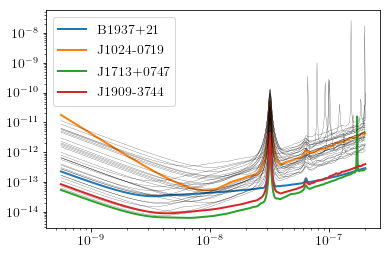

In [34]:
names = ['J1713+0747','B1937+21','J1909-3744','J1024-0719']
for sp,p in zip(spec_11yr,psrs_11yr):
    if p.name in names:
        plt.loglog(sp.freqs,sp.h_c,lw=2,label=p.name)
    else:
        plt.loglog(sp.freqs,sp.h_c, color='k',lw=0.2)

plt.legend()
plt.show()
plt.close()

INFO: matplotlib.texmanager: No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO: matplotlib.texmanager: No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO: matplotlib.texmanager: No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO: matplotlib.texmanager: No LaTeX-compatible font found for the serif font family in rcParams. Using default.


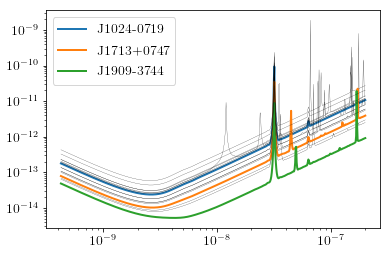

In [35]:
names = ['J1713+0747','B1937+21','J1909-3744','J1024-0719']
for sp,p in zip(spec_mdc2,psrs_mdc2):
    if p.name in names:
        plt.loglog(sp.freqs,sp.h_c,lw=2,label=p.name)
    else:
        plt.loglog(sp.freqs,sp.h_c, color='k',lw=0.2)

plt.legend()
plt.show()
plt.close()

INFO: matplotlib.texmanager: No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO: matplotlib.texmanager: No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO: matplotlib.texmanager: No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO: matplotlib.texmanager: No LaTeX-compatible font found for the serif font family in rcParams. Using default.


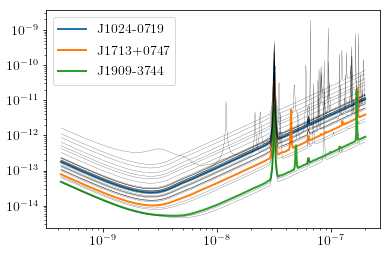

In [36]:
names = ['J1713+0747','B1937+21','J1909-3744','J1024-0719']
for sp,p in zip(spec_injection,psrs_injection):
    if p.name in names:
        plt.loglog(sp.freqs,sp.h_c,lw=2,label=p.name)
    else:
        plt.loglog(sp.freqs,sp.h_c, color='k',lw=0.2)

plt.legend()
plt.show()
plt.close()

In [57]:
sens_curve_11yr = hassen.GWBSensitivityCurve(spec_11yr)
sens_curve_11yr_deter = hassen.DeterSensitivityCurve(spec_11yr)

In [38]:
sens_curve_mdc2 = hassen.GWBSensitivityCurve(spec_mdc2)

In [39]:
sens_curve_injection = hassen.GWBSensitivityCurve(spec_injection)

INFO: matplotlib.texmanager: No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO: matplotlib.texmanager: No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO: matplotlib.texmanager: No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO: matplotlib.texmanager: No LaTeX-compatible font found for the serif font family in rcParams. Using default.


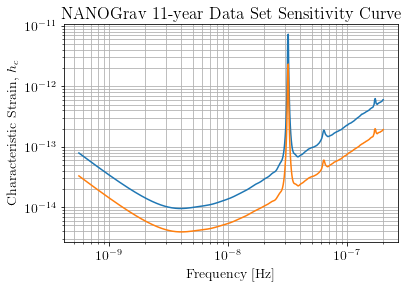

In [58]:
plt.loglog(sens_curve_11yr.freqs,sens_curve_11yr.h_c)
plt.loglog(sens_curve_11yr_deter.freqs,sens_curve_11yr_deter.h_c)
plt.xlabel('Frequency [Hz]')
plt.ylabel('Characteristic Strain, $h_c$')
plt.title('NANOGrav 11-year Data Set Sensitivity Curve')
plt.grid(which='both')
# plt.ylim(1e-15,9e-12)
plt.show()

INFO: matplotlib.texmanager: No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO: matplotlib.texmanager: No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO: matplotlib.texmanager: No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO: matplotlib.texmanager: No LaTeX-compatible font found for the serif font family in rcParams. Using default.


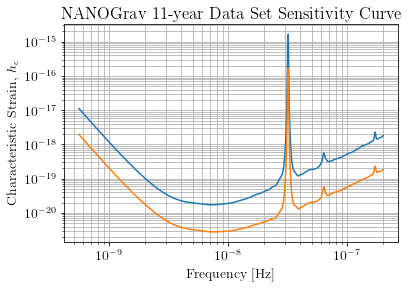

In [59]:
plt.loglog(sens_curve_11yr.freqs,sens_curve_11yr.S_eff)
plt.loglog(sens_curve_11yr_deter.freqs,sens_curve_11yr_deter.S_eff)
plt.xlabel('Frequency [Hz]')
plt.ylabel('Characteristic Strain, $h_c$')
plt.title('NANOGrav 11-year Data Set Sensitivity Curve')
plt.grid(which='both')
# plt.ylim(1e-15,9e-12)
plt.show()

In [60]:
#np.savetxt('NANOGrav_11yr_S_eff.txt',np.transpose([sens_curve_11yr_deter.freqs,sens_curve_11yr_deter.S_eff]))

INFO: matplotlib.texmanager: No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO: matplotlib.texmanager: No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO: matplotlib.texmanager: No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO: matplotlib.texmanager: No LaTeX-compatible font found for the serif font family in rcParams. Using default.


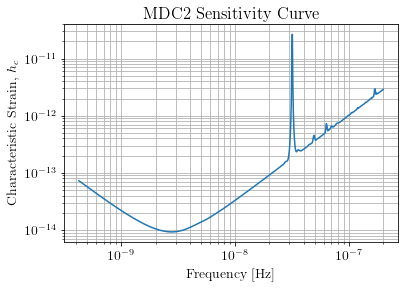

In [41]:
plt.loglog(sens_curve_mdc2.freqs,sens_curve_mdc2.h_c)
plt.xlabel('Frequency [Hz]')
plt.ylabel('Characteristic Strain, $h_c$')
plt.title('MDC2 Sensitivity Curve')
plt.grid(which='both')
# plt.ylim(1e-15,9e-12)
plt.show()

INFO: matplotlib.texmanager: No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO: matplotlib.texmanager: No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO: matplotlib.texmanager: No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO: matplotlib.texmanager: No LaTeX-compatible font found for the serif font family in rcParams. Using default.


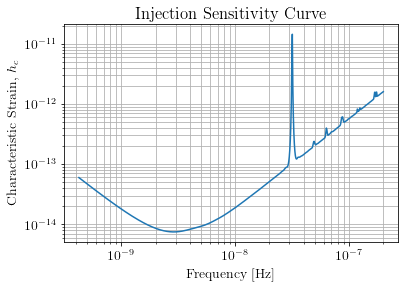

In [42]:
plt.loglog(sens_curve_injection.freqs,sens_curve_injection.h_c)
plt.xlabel('Frequency [Hz]')
plt.ylabel('Characteristic Strain, $h_c$')
plt.title('Injection Sensitivity Curve')
plt.grid(which='both')
# plt.ylim(1e-15,9e-12)
plt.show()

In [31]:
#First for alpha=-2/3 (the default value).
SNR=1
hgw_11yr=hassen.Agwb_from_Seff_plaw(sens_curve_11yr.freqs,
                             Tspan=Tspan_11yr,
                             SNR=SNR,
                             S_eff=sens_curve_11yr.S_eff)
plaw_h_11yr = hgw_11yr*(sens_curve_11yr.freqs/fyr)**(-2/3)

#And for an array of alpha values.
alpha = np.linspace(-7/4,5/4,30)
h_11yr=hassen.Agwb_from_Seff_plaw(freqs=sens_curve_11yr.freqs,Tspan=Tspan_11yr,SNR=SNR,
                           S_eff=sens_curve_11yr.S_eff,alpha=alpha)

plaw_11yr = np.dot((sens_curve_11yr.freqs[:,np.newaxis]/fyr)**alpha,
              h_11yr[:,np.newaxis]*np.eye(30))

In [32]:
#First for alpha=-2/3 (the default value).
SNR=1
hgw_mdc2 =hassen.Agwb_from_Seff_plaw(sens_curve_mdc2.freqs,
                             Tspan=Tspan_mdc2,
                             SNR=SNR,
                             S_eff=sens_curve_mdc2.S_eff)
plaw_h_mdc2 = hgw_mdc2*(sens_curve_mdc2.freqs/fyr)**(-2/3)

#And for an array of alpha values.
alpha = np.linspace(-7/4,5/4,30)
h_mdc2=hassen.Agwb_from_Seff_plaw(freqs=sens_curve_mdc2.freqs,Tspan=Tspan_mdc2,SNR=SNR,
                           S_eff=sens_curve_mdc2.S_eff,alpha=alpha)

plaw_mdc2 = np.dot((sens_curve_mdc2.freqs[:,np.newaxis]/fyr)**alpha,
              h_mdc2[:,np.newaxis]*np.eye(30))

In [61]:
#First for alpha=-2/3 (the default value).
SNR=1
hgw_injection =hassen.Agwb_from_Seff_plaw(sens_curve_injection.freqs,
                             Tspan=Tspan_injection,
                             SNR=SNR,
                             S_eff=sens_curve_injection.S_eff)
plaw_h_injection = hgw_injection*(sens_curve_injection.freqs/fyr)**(-2/3)

#And for an array of alpha values.
alpha = np.linspace(-7/4,5/4,30)
h_injection=hassen.Agwb_from_Seff_plaw(freqs=sens_curve_injection.freqs,Tspan=Tspan_injection,SNR=SNR,
                           S_eff=sens_curve_injection.S_eff,alpha=alpha)

plaw_injection = np.dot((sens_curve_injection.freqs[:,np.newaxis]/fyr)**alpha,
              h_injection[:,np.newaxis]*np.eye(30))

INFO: matplotlib.texmanager: No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO: matplotlib.texmanager: No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO: matplotlib.texmanager: No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO: matplotlib.texmanager: No LaTeX-compatible font found for the serif font family in rcParams. Using default.


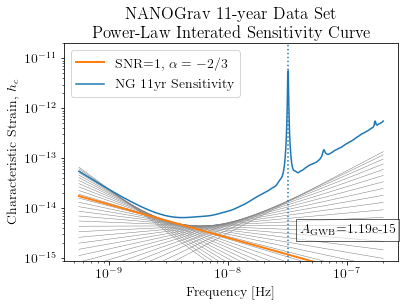

In [64]:
for ii in range(len(h_11yr)):
    plt.loglog(sens_curve_11yr.freqs,plaw_11yr[:,ii],
               color='gray',lw=0.5)
plt.loglog(sens_curve_11yr.freqs,plaw_h_11yr,color='C1',lw=2,
           label='SNR={0}, '.format(SNR)+r'$\alpha=-2/3$')
plt.loglog(sens_curve_11yr.freqs,sens_curve_11yr.h_c, label='NG 11yr Sensitivity')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Characteristic Strain, $h_c$')
plt.axvline(fyr,linestyle=':')
plt.rc('text', usetex=True)
plt.title('NANOGrav 11-year Data Set\nPower-Law Interated Sensitivity Curve')
plt.ylim(hgw_11yr*0.75,2e-11)
plt.text(x=4e-8,y=3e-15,
         s=r'$A_{\rm GWB}$='+'{0:1.2e}'.format(hgw_11yr),
         bbox=dict(facecolor='white', alpha=0.6))
plt.legend(loc='upper left')
plt.show()

INFO: matplotlib.texmanager: No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO: matplotlib.texmanager: No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO: matplotlib.texmanager: No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO: matplotlib.texmanager: No LaTeX-compatible font found for the serif font family in rcParams. Using default.


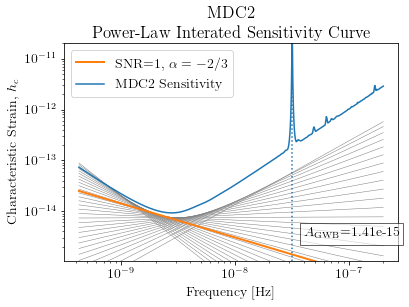

In [66]:
for ii in range(len(h_mdc2)):
    plt.loglog(sens_curve_mdc2.freqs,plaw_mdc2[:,ii],
               color='gray',lw=0.5)
plt.loglog(sens_curve_mdc2.freqs,plaw_h_mdc2,color='C1',lw=2,
           label='SNR={0}, '.format(SNR)+r'$\alpha=-2/3$')
plt.loglog(sens_curve_mdc2.freqs,sens_curve_mdc2.h_c, label='MDC2 Sensitivity')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Characteristic Strain, $h_c$')
plt.axvline(fyr,linestyle=':')
plt.rc('text', usetex=True)
plt.title('MDC2 \nPower-Law Interated Sensitivity Curve')
plt.ylim(hgw_mdc2*0.75,2e-11)
plt.text(x=4e-8,y=3e-15,
         s=r'$A_{\rm GWB}$='+'{0:1.2e}'.format(hgw_mdc2),
         bbox=dict(facecolor='white', alpha=0.6))
plt.legend(loc='upper left')
plt.show()

INFO: matplotlib.texmanager: No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO: matplotlib.texmanager: No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO: matplotlib.texmanager: No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO: matplotlib.texmanager: No LaTeX-compatible font found for the serif font family in rcParams. Using default.


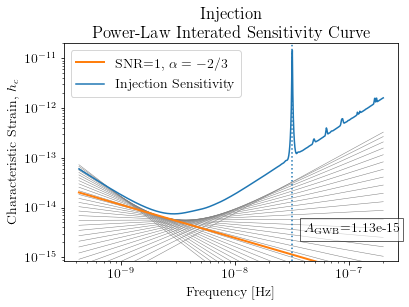

In [68]:
for ii in range(len(h_injection)):
    plt.loglog(sens_curve_injection.freqs,plaw_injection[:,ii],
               color='gray',lw=0.5)
plt.loglog(sens_curve_injection.freqs,plaw_h_injection,color='C1',lw=2,
           label='SNR={0}, '.format(SNR)+r'$\alpha=-2/3$')
plt.loglog(sens_curve_injection.freqs,sens_curve_injection.h_c, label='Injection Sensitivity')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Characteristic Strain, $h_c$')
plt.axvline(fyr,linestyle=':')
plt.rc('text', usetex=True)
plt.title('Injection \nPower-Law Interated Sensitivity Curve')
plt.ylim(hgw_injection*0.75,2e-11)
plt.text(x=4e-8,y=3e-15,
         s=r'$A_{\rm GWB}$='+'{0:1.2e}'.format(hgw_injection),
         bbox=dict(facecolor='white', alpha=0.6))
plt.legend(loc='upper left')
plt.show()